# MNIST Digit Recognition

## 1. Data Preparation

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

batch_size = 128
# datasets.MNIST(root : 경로지정, train : train or test 데이터를 받아옴, download : 데이터 셋이 없을 때, transform: 사전에 설정해 놓은 데이터 처리 형태)
# transform.Compose : 데이터를 전처리하는 패키지
# ([transforms.ToTensor(): 데이터 타입을 Tensor로 변경((),()) : transforms.Normalize : 이미지는 픽셀 값 하나에 0~255 값을 가짐. 하지만 ToTensor()로 타입 변경시 0~1 사이의 값으로 바뀜])
# ToTensor : scaling 해준 것, Normalize : entering + rescaling을 해준 것
train_dataset = datasets.MNIST('./data', train=True, download=True,
                               transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))  # transforms.Nomalize : 각 channel에 맞춰서 normalize
test_dataset = datasets.MNIST('./data/', train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

# batch_size : 한 번 sampling할 때 얼마나 많은 데이터를 뽑아올지
# shuffle=True : epoch 마다 데이터 셋을 섞어줌
# num_workers : data loading을 위해 얼마나 많은 subprocess를 사용할 것인지 설정(스래드 갯수)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)  # DataLoader : 데이터 셋을 샘플러와 병합하여 iterable한 형태로 출력해줌. 즉, for문이 가능해짐
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)     # val은 train처럼 shuffle=True해도 상관 없나? 상관없지만 train만 True로 하는 것이 일반적임
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

50000 10000 10000


## Inspecting Dataset

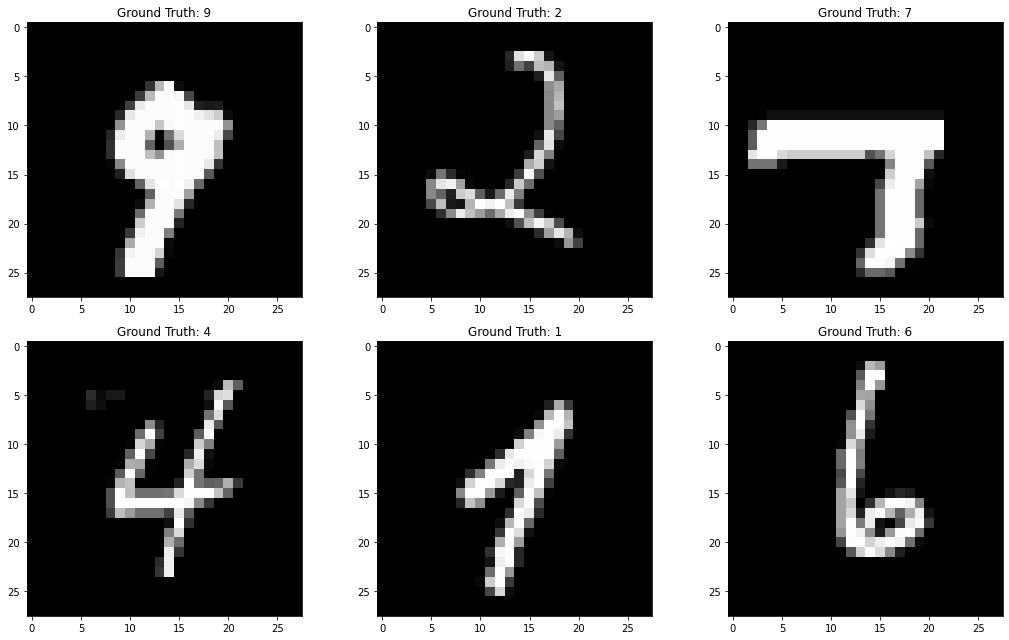

In [2]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  # next : 하나씩 다음으로 넘긴다

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()  # subplot 간에 올바른 간격을 자동으로 유지
    plt.imshow(example_data[i][0],  cmap='gray', interpolation='none')  # interpolation? example_data[i][0]의 의미?
    plt.title('Ground Truth: {}'.format(example_targets[i]))
plt.show()


## 2. Model Architecture

In [3]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear_layer = nn.Linear(in_features=784, out_features=10, bias=True)
        
    def forward(self, x):
        x = self.linear_layer(x)
        return x

## 3. Cost Function Define(Loss Function Define)

In [4]:
criterion = nn.CrossEntropyLoss()

## Train & Evaluation

In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# =====Construct Model===== #
model = LinearModel()
print('Number of {} parameters'.format(sum(p.numel()for p in model.parameters() if p.requires_grad)))

# =====Construct Optimizer===== #
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

epoch_lst = []
train_loss_lst = []
val_loss_lst = []
acc_lst = []
acc_epoch_lst = []

epoch = 30
for i in range(epoch):
    
    # =====Train===== #
    train_loss = 0
    model.train()
    
    for X_input, y_true in train_loader: # 50,000 = 128*390 + 80(마지막 391번째 묶음은 80개가 들어있음)
        optimizer.zero_grad()            # 매 iteration 마다 zero_grad() 실행
        
        X_input = X_input.squeeze()      # torch.Size([128, 1, 28, 28]) -> ([128, 28, 28])
        X_input = X_input.view(-1, 784)  # torch.Size([128, 28, 28]) -> ([128, 784]) / View는 numpy의 reshape와 같은 역할
        y_pred = model(X_input)
        
        loss = criterion(y_pred.squeeze(), y_true)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().numpy()      # Tensor -> numpy로 변경 
    train_loss = train_loss / len(train_loader)  # len(train_loader) : 391
    train_loss_lst.append(train_loss)
    epoch_lst.append(i)
    
  
    # =====Validation===== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad()  # 아래 torch.no_grad()가 호출되고, Validation과정에서는 Optimizer을 사용하지 않아서 호출할 필요 없음
    
    # no_grad() : autograd를 꺼서 메모리 사용량을 줄이고 연산 속도를 높힘
    with torch.no_grad():  # Validation 과정에서 gradient가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행
        for X_input, y_true in val_loader:
            X_input = X_input.squeeze()
            X_input = X_input.view(-1, 784)
            y_pred = model(X_input)
            
            loss = criterion(y_pred.squeeze(), y_true)
            val_loss += loss.detach().numpy()
        val_loss = val_loss / len(val_loader)
        val_loss_lst.append(val_loss)
        
    
    # =====Evaluation===== #
    correct = 0
    model.eval()
        
    with torch.no_grad():
        for X_input, y_true in test_loader:
            X_input = X_input.squeeze()
            X_input = X_input.view(-1, 784)
            # max(input, dim, keepdim) / input : Tensor을 의미
            # keepdim : max 연산을 한 축을 생략할 지 그대로 둘 지에 대한 기준
            y_pred = model(X_input).max(1, keepdim=True)[1].squeeze()  # 가장 큰 확률로 예측한 숫자
            correct += y_pred.eq(y_true).sum()  # eq() : 값이 일치하면 1을, 아니면 0을 출력
            
        acc = correct.numpy() / len(test_loader.dataset)  # tensor 형태이기 때문에 correct.numpy()를 해줌 / len(test_loader.dataset) : 10000
        acc_lst.append(acc)
        acc_epoch_lst.append(i)
        
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Number of 7850 parameters
Epoch: 0, Train Loss: 0.7420348720172482, Val Loss: 0.49147237705279, Test Acc: 88.32%
Epoch: 1, Train Loss: 0.4386337227985987, Val Loss: 0.4192919576469856, Test Acc: 89.57000000000001%
Epoch: 2, Train Loss: 0.389219298920668, Val Loss: 0.3877939804445339, Test Acc: 90.27%
Epoch: 3, Train Loss: 0.3645927241391233, Val Loss: 0.37100948506518255, Test Acc: 90.75%
Epoch: 4, Train Loss: 0.3488246944096997, Val Loss: 0.359240090733842, Test Acc: 90.96%
Epoch: 5, Train Loss: 0.33776343886352256, Val Loss: 0.3505661996859538, Test Acc: 91.22%
Epoch: 6, Train Loss: 0.3296746544139769, Val Loss: 0.34424134183533583, Test Acc: 91.32000000000001%
Epoch: 7, Train Loss: 0.32291868081330644, Val Loss: 0.3396862226573727, Test Acc: 91.33%
Epoch: 8, Train Loss: 0.3175747490218838, Val Loss: 0.3346949155572094, Test Acc: 91.51%
Epoch: 9, Train Loss: 0.3128699068828007, Val Loss: 0.33215004281152655, Test Acc: 91.44%
Epoch: 10, Train Loss: 0.30889717819135815, Val Loss: 0.329

## 5. Report Experiment
- 학습 과정에서 기록했던 train_loss와 val_loss 그리기
- Loss가 꾸준히 줄어드는지 확인
- val_loss가 증가하기 시작하면, 그 이상의 학습은 점점 모델의 성능을 망친다는 것을 의미
- Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인


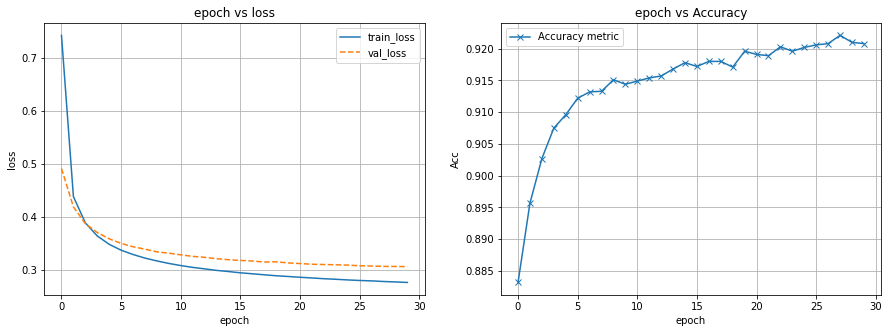

In [6]:
fig = plt.figure(figsize=(15, 5))

# =====Loss Fluctuation===== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epoch_lst, train_loss_lst, label='train_loss')
ax1.plot(epoch_lst, val_loss_lst, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# =====Metric Fluctuation===== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epoch_lst, acc_lst, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()
